In [1]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
%matplotlib notebook

In this project, I explored two execution approaches: Market Taking and Opportunistic Market Making. First, Market Taking (MT) method allows us to send market orders and aggress market immediately with the latest quotes. On the other hand, Opportunistic Market Making (OMM) method is risky, which will send limit orders and wait under the certain time limit for a more beneficial price to fill the order. More specifically, OMM can also be divided into 2 types according to how the limit order prices are set: OMMMid will set the mid-market price as the limit price; OMMSide will set a limit price on your side. 

In the first step, I dealt with the Market Taking(MT) method.
I calculated the mid-arket prices and calculated PnL under Market Taking(MT) scenario.

In the second step, I dealt with the Opportunistic Market Making(OMMT) method.
First, I dealt with OMMMid type.
I set a range of the time to execution but would use 10s as the time limit in the analysis. Also, I set 0.0003 as the maximum loss. Then I calculated PnL under 3 scenarios:                         
(1) In 10s, there is a more beneficial price coming, I would execute the order and aggress the market immediately when the price shows up.            
(2) In 10s, there is no beneficial price showing up and do not reach the maximum loss, the Time Limit order would be executed.               
(3) If there is no beneficial price showing up but it reaches the maximum loss, the Stop Loss order would be executed.
Second, I dealt with OMMSide type using similar analysis.

In the third step, I would analyze the result.
I compared the average and median PnL for each order, and the average and median TTE for each order.
I counted the number of times when Stop Loss was triggered for OMMMid and OMMSide.
I also counted the number of times when Time Limit was triggered for OMMMid and OMMSide.
I changed the time to execution(TTE) to see the influence of TTE on the median PnL.
I compared differences of three alpha generators: DIS, MAR, SOM.

# 1. Data Process

First, I uploaded the data given.

In [2]:
# data contains Bid Ask data in the market.
data = pd.read_csv('2.csv', encoding='utf-16-le', index_col = 0)
data.index = pd.to_datetime(data.index)

In [3]:
# orders contains orders information.
orders = pd.read_excel("Assignment#3_Orders.xlsx", index_col = False)
orders['datetime'] = pd.to_datetime(orders['datetime'], format = "%Y-%m-%d %H:%M:%S")

Second, I calculated the mid-market prices using ask prices and bid prices.

In [5]:
# Calculate the mid-market prices.
data['Mid'] = (data['Ask'] + data['Bid']) / 2

In [75]:
data.head()

,Bid,Ask,Mid
DateTime,,,
2018-01-07 22:02:03.832,1.35560,1.35616,1.355880
2018-01-07 22:02:03.845,1.35560,1.35617,1.355885
2018-01-07 22:02:03.851,1.35554,1.35617,1.355855
2018-01-07 22:02:03.859,1.35554,1.35618,1.355860
2018-01-07 22:02:04.114,1.35554,1.35619,1.355865


Third, I referred to the bid-ask market to find out the next closest time for each order.

In [6]:
# For each order, define a function to search for the next closest time in the bid-ask market.
def find_next(data, time):
    # time: pd.datetime
    # given a timestamp, find the next observation's index in our dataset
    left, right = 0, len(data) - 1
    if data.index[left] >= time:
        return left
    if data.index[right] <= time:
        return right
    mid = (left + right) // 2
    while mid > left:
        if data.index[mid] == time:
            return mid
        elif data.index[mid] > time:
            right = mid
            mid = (left + right) // 2
        else:
            left = mid
            mid = (left + right) // 2
    return mid + 1

## 1. Market Taking method

In this step, I calculated the PnL under Market Taking(MT) method.
Whenever buying or selling it, under MT method, we take the market. Thus we would execute our orders under the market prices. We would buy at the latest ask price and sell at the latest bid price.

In [7]:
for i in range(0,len(orders)):
    t = find_next(data, orders.loc[orders.index[i], 'datetime'])
    
    if orders.loc[orders.index[i]]['buy/sell']==1:
        # 1 stands for buying
        orders.loc[orders.index[i],'MT_PnL'] = data.iloc[t]['Mid'] - data.iloc[t]['Ask']
    else:
        # -1 stands for selling
        orders.loc[orders.index[i],'MT_PnL'] = data.iloc[t]['Bid'] - data.iloc[t]['Mid']

In [8]:
orders.head(10)

,trade_id,buy/sell,notional,executed price,datetime,instrument,alpha,MT_PnL
0,107414,1,150000,1.35724,2018-01-07 19:07:49,GBP/USD,SOM,-0.000280
1,107427,1,310000,1.35725,2018-01-07 19:15:23,GBP/USD,SOM,-0.000280
2,107638,-1,310000,1.35453,2018-01-08 07:38:48,GBP/USD,SOM,-0.000010
3,107649,-1,310000,1.35371,2018-01-08 08:10:55,GBP/USD,SOM,-0.000020
4,107654,-1,320000,1.35394,2018-01-08 08:19:10,GBP/USD,SOM,-0.000015
5,107664,-1,200000,1.35405,2018-01-08 08:23:16,GBP/USD,SOM,-0.000020
6,107670,-1,490000,1.35423,2018-01-08 08:34:40,GBP/USD,SOM,-0.000005
7,107726,1,200000,1.35716,2018-01-08 11:25:13,GBP/USD,SOM,-0.000025
8,107733,1,310000,1.35693,2018-01-08 11:42:08,GBP/USD,SOM,-0.000020
9,107737,1,310000,1.35676,2018-01-08 12:15:34,GBP/USD,SOM,-0.000025


## 2. OMMMid method

In this step, I calculated PnL when Time to Execution is 10s. I also counted the number of Time Limit is triggered and the number of Stop Loss is triggered.

In [9]:
# From the next closest time we found in data, we compared the time interval of it to next data,
# if the time interval is larger than 10s we will do the follwing on the next data.
# if the time interval is shorter than 10s we will compare to the third data until the 60th data.
# When we are buying, if the time interval is shorter than 10s and it does not reach the maximum loss,
# The OMMMid Stop Loss and Time Limit are not triggered     
# When we get a beneficial price, we would execute our order at the mid-market price
# When we do not get the beneficial price in 10s, we would wait until the Stop Loss or Time Limit
# to be triggered or wait for a beneficial price
# Similar to a seller

for i in range(0,len(orders)):
    t = find_next(data, orders.loc[orders.index[i], 'datetime'])
    for delta in range(1,60):
        if orders.loc[orders.index[i]]['buy/sell']==1:
            if data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 0
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 0
                if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    orders.loc[orders.index[i], 'Mid_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                    break

            elif data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']<=-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 0
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 1
                if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']
                orders.loc[orders.index[i], 'Mid_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                break

            elif data.index[t+delta]-data.index[t]>=timedelta(seconds=10) and data.iloc[t+delta]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 1
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 0
                orders.loc[orders.index[i], 'Mid_TTE'] = 10
                if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']
                
                break
                
            else:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 1
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 1
                orders.loc[orders.index[i], 'Mid_TTE'] = 10
                if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']
                break
                     
        else:
            if data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 0
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 0
                if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    orders.loc[orders.index[i], 'Mid_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                    break

            elif data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']<=-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 0
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 1
                if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']
                orders.loc[orders.index[i], 'Mid_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                break

            elif data.index[t+delta]-data.index[t]>=timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 1
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 0
                orders.loc[orders.index[i], 'Mid_TTE'] = 10
                if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']
                
                break
                
            else:
                orders.loc[orders.index[i], 'MidTL_Trigger'] = 1
                orders.loc[orders.index[i], 'MidSL_Trigger'] = 1
                orders.loc[orders.index[i], 'Mid_TTE'] = 10
                if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                else:
                    orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']
               
                break

In [13]:
orders

,trade_id,buy/sell,notional,executed price,datetime,instrument,alpha,MT_PnL,MidTL_Trigger,MidSL_Trigger,OMMMid_PnL,Mid_TTE
0,107414,1,150000,1.35724,2018-01-07 19:07:49,GBP/USD,SOM,-0.000280,0.0,1.0,-0.000290,10454.845
1,107427,1,310000,1.35725,2018-01-07 19:15:23,GBP/USD,SOM,-0.000280,0.0,1.0,-0.000290,10000.845
2,107638,-1,310000,1.35453,2018-01-08 07:38:48,GBP/USD,SOM,-0.000010,0.0,0.0,0.000000,1.787
3,107649,-1,310000,1.35371,2018-01-08 08:10:55,GBP/USD,SOM,-0.000020,0.0,0.0,0.000000,6.082
4,107654,-1,320000,1.35394,2018-01-08 08:19:10,GBP/USD,SOM,-0.000015,0.0,1.0,-0.000035,1.096
5,107664,-1,200000,1.35405,2018-01-08 08:23:16,GBP/USD,SOM,-0.000020,1.0,0.0,-0.000010,10.000
6,107670,-1,490000,1.35423,2018-01-08 08:34:40,GBP/USD,SOM,-0.000005,0.0,0.0,0.000000,0.878
7,107726,1,200000,1.35716,2018-01-08 11:25:13,GBP/USD,SOM,-0.000025,0.0,1.0,-0.000035,3.331
8,107733,1,310000,1.35693,2018-01-08 11:42:08,GBP/USD,SOM,-0.000020,0.0,1.0,-0.000030,0.314
9,107737,1,310000,1.35676,2018-01-08 12:15:34,GBP/USD,SOM,-0.000025,0.0,0.0,0.000000,4.265


I calculated the number of Time Limit is triggered and the number of Stop Loss is triggered.

In [11]:
# When TTE is 10s, count the number of times when Time Limit is triggered and the number
# of times when Stop Loss is triggered
print('For OMMMid, when TTE=10s and MaxLoss=0.00003')
print('the number of times when Time Limit orders were triggered:', orders.MidTL_Trigger.sum())
print('the number of times when Stop Loss orders were triggered:', orders.MidSL_Trigger.sum())

For OMMMid, when TTE=10s and MaxLoss=0.00003
the number of times when Time Limit orders were triggered: 62.0
the number of times when Stop Loss orders were triggered: 174.0


## 3. OMMSide method

In this step, I calculated PnL when Time to Execution is 10s. I also counted the number of Time Limit is triggered and the number of Stop Loss is triggered under OMMSide method.

In [14]:
# From the next closest time we found in data, we compared the time interval of it to next data,
# if the time interval is larger than 10s we will do the follwing on the next data.
# if the time interval is shorter than 10s we will compare to the third data until the 60th data.
# When we are buying, if the time interval is shorter than 10s and it does not reach the maximum loss,
# The OMMMid Stop Loss and Time Limit are not triggered     
# When we get a beneficial price by our side, we would execute our order and aggress the market immediately
# When we do not get the beneficial price in 10s, we would wait until the Stop Loss or Time Limit
# to be triggered or wait for next beneficial price
# Similar to a seller

for i in range(0,len(orders)):
    t = find_next(data, orders.loc[orders.index[i], 'datetime'])
    for delta in range(1,60):
        if orders.loc[orders.index[i]]['buy/sell']==1:
            if data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 0
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 0
                if data.iloc[t+delta]['Ask']<=data.iloc[t]['Bid']:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                    orders.loc[orders.index[i], 'Side_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                    break
               
            elif data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']<=-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 0
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 1
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                orders.loc[orders.index[i], 'Side_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                break

            elif data.index[t+delta]-data.index[t]>=timedelta(seconds=10) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 1
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 0
                orders.loc[orders.index[i], 'Side_TTE'] = 10
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                break
                
            else:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 1
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 1
                orders.loc[orders.index[i], 'Side_TTE'] = 10
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                break
                     
        else:
            if data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 0
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 0
                if data.iloc[t+delta]['Bid']>=data.iloc[t]['Ask']:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                    orders.loc[orders.index[i], 'Side_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                    break
               
            elif data.index[t+delta]-data.index[t]<timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']<=-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 0
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 1
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                orders.loc[orders.index[i], 'Side_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()
                break

            elif data.index[t+delta]-data.index[t]>=timedelta(seconds=10) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 1
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 0
                orders.loc[orders.index[i], 'Side_TTE'] = 10
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                break
                
            else:
                orders.loc[orders.index[i], 'SideTL_Trigger'] = 1
                orders.loc[orders.index[i], 'SideSL_Trigger'] = 1
                orders.loc[orders.index[i], 'Side_TTE'] = 10
                orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                break

I calculated the number of Time Limit is triggered and the number of Stop Loss is triggered.

In [15]:
# When TTE is 10s, count the number of times when Time Limit is triggered and the number
# of times when Stop Loss is triggered
print('For OMMSide, when TTE=10s and MaxLoss=0.00003')
print('the number of times when Time Limit orders were triggered:', orders.SideTL_Trigger.sum())
print('the number of times when Stop Loss orders were triggered:', orders.SideSL_Trigger.sum())

For OMMSide, when TTE=10s and MaxLoss=0.00003
the number of times when Time Limit orders were triggered: 82.0
the number of times when Stop Loss orders were triggered: 181.0


In [16]:
orders

,trade_id,buy/sell,notional,executed price,datetime,instrument,alpha,MT_PnL,MidTL_Trigger,MidSL_Trigger,OMMMid_PnL,Mid_TTE,SideTL_Trigger,SideSL_Trigger,OMMSide_PnL,Side_TTE
0,107414,1,150000,1.35724,2018-01-07 19:07:49,GBP/USD,SOM,-0.000280,0.0,1.0,-0.000290,10454.845,0.0,1.0,-2.900000e-04,10454.845
1,107427,1,310000,1.35725,2018-01-07 19:15:23,GBP/USD,SOM,-0.000280,0.0,1.0,-0.000290,10000.845,0.0,1.0,-2.900000e-04,10000.845
2,107638,-1,310000,1.35453,2018-01-08 07:38:48,GBP/USD,SOM,-0.000010,0.0,0.0,0.000000,1.787,0.0,0.0,2.000000e-05,2.407
3,107649,-1,310000,1.35371,2018-01-08 08:10:55,GBP/USD,SOM,-0.000020,0.0,0.0,0.000000,6.082,0.0,0.0,2.000000e-05,6.082
4,107654,-1,320000,1.35394,2018-01-08 08:19:10,GBP/USD,SOM,-0.000015,0.0,1.0,-0.000035,1.096,0.0,1.0,-3.500000e-05,1.096
5,107664,-1,200000,1.35405,2018-01-08 08:23:16,GBP/USD,SOM,-0.000020,1.0,0.0,-0.000010,10.000,1.0,0.0,-1.000000e-05,10.000
6,107670,-1,490000,1.35423,2018-01-08 08:34:40,GBP/USD,SOM,-0.000005,0.0,0.0,0.000000,0.878,0.0,0.0,5.000000e-06,0.878
7,107726,1,200000,1.35716,2018-01-08 11:25:13,GBP/USD,SOM,-0.000025,0.0,1.0,-0.000035,3.331,0.0,1.0,-3.500000e-05,3.331
8,107733,1,310000,1.35693,2018-01-08 11:42:08,GBP/USD,SOM,-0.000020,0.0,1.0,-0.000030,0.314,0.0,1.0,-3.000000e-05,0.314
9,107737,1,310000,1.35676,2018-01-08 12:15:34,GBP/USD,SOM,-0.000025,0.0,0.0,0.000000,4.265,0.0,0.0,2.500000e-05,4.333


# 2. Analysis

## 1. PnL performance under the 3 methods

I plotted the PnLs under 3 methods.

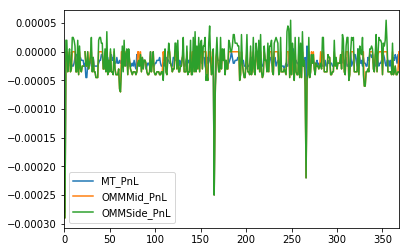

In [19]:
%matplotlib inline
orders['MT_PnL'].plot()
orders['OMMMid_PnL'].plot()
orders['OMMSide_PnL'].plot()
plt.legend()

From the above result, I found that:    
PnL under OMMSide method is more volatile.

Next, I calculated the average and median PnL under each method.

In [20]:
# Market Taking average PnL
MT_mean = orders['MT_PnL'].mean()
# Market Taking median PnL
MT_median = orders['MT_PnL'].median()

# OMMMid average PnL
Mid_mean = orders['OMMMid_PnL'].mean()
# OMMMid median PnL
Mid_median = orders['OMMMid_PnL'].median()

# OMMSide average PnL
Side_mean = orders['OMMSide_PnL'].mean()
# OMMSide median PnL
Side_median = orders['OMMSide_PnL'].median()

# The volatility of PnL under each method
MT_std = orders['MT_PnL'].std()
Mid_std = orders['OMMMid_PnL'].std()
Side_std = orders['OMMSide_PnL'].std()

In [21]:
pnl = {'MT':[MT_mean, MT_median, MT_std], 'OMMMid':[Mid_mean, Mid_median, Mid_std], 'OMMSide':[Side_mean, Side_median, Side_std]}
PnL = pd.DataFrame(data = pnl, index = ['PnL_mean', 'PnL_median', 'PnL_std'])
PnL

,MT,OMMMid,OMMSide
PnL_mean,-0.000020,-0.000023,-0.000018
PnL_median,-0.000020,-0.000025,-0.000025
PnL_std,0.000026,0.000031,0.000037


By comparing the average PnLs and the median PnLs of the 3 execution methods, I found that:

OMMSide_PnL > OMMMid_PnL > MT_PnL

OMMSide has the highest PnL as the result of successfully taking opportunistic executions. Whiel Market Taking method has a lower average PnL and minimum median PnL because it is the least risky.

In addition to required statistics, I added the volatility of PnLs for better analysis.

From the above table, we can see that OMMSide method has the highest volatility because it is more risky while MT method has the lowest volatility. OMMMid PnL also has a relatively higher volatility because it also take into consideration opportunities.

## 2. Comparing TTE of OMMMid and OMMSide methods

I calculated the mean and median TTE for OMMMid method and OMMSide method.

In [23]:
# Because the first 2 data in orders file couldn't find the next closest time in data file and are considered outliers, 
# When I calculated average and median TTE, I didn't take thse 2 data into consideration.
MidTTE_mean = orders['Mid_TTE'][2:].mean()
MidTTE_median = orders['Mid_TTE'][2:].median()

SideTTE_mean = orders['Side_TTE'][2:].mean()
SideTTE_median = orders['Side_TTE'][2:].median()

tte = {'OMMMid':[MidTTE_mean, MidTTE_median], 'OMMSide':[SideTTE_mean, SideTTE_median]}
TTE = pd.DataFrame(data = tte, index = ['TTE_mean', 'TTE_median'])

TTE

,OMMMid,OMMSide
TTE_mean,4.708074,5.315311
TTE_median,3.220000,4.329000


By comparing the average TTEs and the median TTEs of the OMMMid and OMMSide execution methods, I found that:     
OMMSide_TTE > OMMMid_TTE      
OMMSide tends to have longer median and average Time to Execution because under this method, we would like to wait for a profit price by our side, it would relatively take more time.

I calculated the times of Time Limit was triggered and Stop Loss was triggered under OMMMid and OMMSide methods.

In [26]:
MidTL_trigger = orders['MidTL_Trigger'].sum()
MidSL_trigger = orders['MidSL_Trigger'].sum()

SideTL_trigger = orders['SideTL_Trigger'].sum()
SideSL_trigger = orders['SideSL_Trigger'].sum()

trigger = {'OMMMid':[MidTL_trigger, MidSL_trigger], 'OMMSide':[SideTL_trigger, SideSL_trigger]}
Trigger = pd.DataFrame(data = trigger, index = ['TimeLimit_trigger', 'StopLoss_trigger'])

Trigger

,OMMMid,OMMSide
TimeLimit_trigger,62.0,82.0
StopLoss_trigger,174.0,181.0


By comparing, I found that:
OMMSide incurs more Timit Limit trigger and Stop Loss trigger compared to OMMMid method.  
Both methods incur more Stop Loss trigger than Time Limit trigger.

## 3. Recapitulating table

In [29]:
Result1 = PnL
Result2 = Result1.append(TTE)
Result = Result2.append(Trigger)
Result

,MT,OMMMid,OMMSide
PnL_mean,-0.000020,-0.000023,-0.000018
PnL_median,-0.000020,-0.000025,-0.000025
PnL_std,0.000026,0.000031,0.000037
TTE_mean,NaN,4.708074,5.315311
TTE_median,NaN,3.220000,4.329000
TimeLimit_trigger,NaN,62.000000,82.000000
StopLoss_trigger,NaN,174.000000,181.000000


Above is the final result of the 3 methods. 
We can see that:          

First, MT method has the highest median PnL because it is less risky, while OMMSide has the highest average PnL because it has more opportunities to profit. However, PnL under OMMSide method has the highest volatility while under MT method has the lowest volatility because the latter is less risky.             

Second, OMMSide tends to have a longer median time to execution and average time to execution because we would wait for a profit price within the limit of time and maximum loss under OMMSide method.               

Finally, OMMSide method would incure Time Limit trigger more while OMMMid method would incur Time Limit trigger less. Also, OMMSide method would incur Stop Loss trigger more while OMMMid method would incur Stop Loss trigger less. Both methods would incur more Stop Loss trigger than Time Limit trigger.

MT method tends to have limited PnL but its volatility is smaller. Although OMMSide has the highest average PnL, its average execution time is also the largest which means it is exposed to more market risk. Further more, in consistence with common scense, OMMSide is more likely to touch SL and TTE limit than OMMMid, since it sets a more 'opportunistic' limit price.

# 3. Further Analysis

## 1. The influence of TTE

First, I changed the length of Time to Execution(TTE) to see its influence on the median PnLs under the OMMMid and OMMSide methods.

### 1. Under OMMMid method

In [45]:
def OMMMid(orders, data, tte):  

# From the next closest time we found in data, we compared the time interval of it to next data,
# if the time interval is larger than 10s we will do the follwing on the next data.
# if the time interval is shorter than 10s we will compare to the third data until the 60th data.
# When we are buying, if the time interval is shorter than 10s and it does not reach the maximum loss,
# The OMMMid Stop Loss and Time Limit are not triggered     
# When we get a beneficial price, we would execute our order at the mid-market price
# When we do not get the beneficial price in 10s, we would wait until the Stop Loss or Time Limit
# to be triggered or wait for a beneficial price
# Similar to a seller

    for i in range(0,len(orders)):
        t = find_next(data, orders.loc[orders.index[i], 'datetime'])
        for delta in range(1,60):
            if orders.loc[orders.index[i]]['buy/sell']==1:
                if data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                    if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                        break
                    #else:
                        #orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Mid']  - data.iloc[t+delta]['Ask']
                        #orders.loc[orders.index[i], 'Mid_TTE'] = (data.index[t+delta] - orders.loc[orders.index[i], 'datetime']).total_seconds()

                elif data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']<=-0.00003:
                    if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']
                    break

                elif data.index[t+delta]-data.index[t]>=timedelta(seconds=tte) and data.iloc[t+delta]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                    if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']

                    break

                else:
                    if data.iloc[t+delta]['Ask']<=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t]['Mid']  - data.iloc[t+delta]['Ask']
                    break

            else:
                if data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                    if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                        break
                   
                elif data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']<=-0.00003:
                    if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']
                    break

                elif data.index[t+delta]-data.index[t]>=timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                    if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']

                    break

                else:
                    if data.iloc[t+delta]['Bid']>=data.iloc[t]['Mid']:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = 0
                    else:
                        orders.loc[orders.index[i],'OMMMid_PnL'] = data.iloc[t+delta]['Bid']  - data.iloc[t]['Mid']

                    break

    return orders, orders['OMMMid_PnL'].median()

In [46]:
OMMMid_tables = []
OMMMid_medians = []

# Change the length of TTE
for tte in [10, 30, 45, 60, 90, 120, 150, 165, 180, 210]:
    order, median = OMMMid(orders, data, tte)
    OMMMid_tables.append(order)
    OMMMid_medians.append(median)

In [76]:
OMMMid_medians

[-2.4999999999941735e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05]

### 2. Under OMMSide method

In [42]:
def OMMSide(orders, data, tte):  
# From the next closest time we found in data, we compared the time interval of it to next data,
# if the time interval is larger than 10s we will do the follwing on the next data.
# if the time interval is shorter than 10s we will compare to the third data until the 60th data.
# When we are buying, if the time interval is shorter than 10s and it does not reach the maximum loss,
# The OMMMid Stop Loss and Time Limit are not triggered     
# When we get a beneficial price, we would execute our order at the mid-market price
# When we do not get the beneficial price in 10s, we would wait until the Stop Loss or Time Limit
# to be triggered or wait for a beneficial price
# Similar to a seller

    for i in range(0,len(orders)):
        t = find_next(data, orders.loc[orders.index[i], 'datetime'])
        for delta in range(1,60):
            if orders.loc[orders.index[i]]['buy/sell']==1:
                if data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                    if data.iloc[t+delta]['Ask']<=data.iloc[t]['Bid']:
                        orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                        break

                elif data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']<=-0.00003:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                    break

                elif data.index[t+delta]-data.index[t]>=timedelta(seconds=tte) and data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']>-0.00003:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                    break

                else:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t]['Mid']-data.iloc[t+delta]['Ask']
                    break

            else:
                if data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                    if data.iloc[t+delta]['Bid']>=data.iloc[t]['Ask']:
                        orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                        break

                elif data.index[t+delta]-data.index[t]<timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']<=-0.00003:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                    break

                elif data.index[t+delta]-data.index[t]>=timedelta(seconds=tte) and data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']>-0.00003:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                    break

                else:
                    orders.loc[orders.index[i],'OMMSide_PnL'] = data.iloc[t+delta]['Bid']-data.iloc[t]['Mid']
                    break
                    
    return orders, orders['OMMSide_PnL'].median()

In [43]:
OMMSide_tables = []
OMMSide_medians = []

# Change the length of TTE
for tte in [10, 30, 45, 60, 90, 120, 150, 165, 180, 210]:
    orders['SideTL_Trigger'] = 0
    orders['SideSL_Trigger'] = 0
    order, median = OMMSide(orders, data, tte)
    OMMSide_tables.append(order)
    OMMSide_medians.append(median)

In [77]:
OMMSide_medians

[-2.500000000016378e-05,
 -3.0000000000196536e-05,
 -3.0000000000196536e-05,
 -3.249999999999087e-05,
 -3.49999999997852e-05,
 -3.49999999997852e-05,
 -3.49999999997852e-05,
 -3.49999999997852e-05,
 -3.49999999997852e-05,
 -3.49999999997852e-05]

### 3. PnL under different TTEs 

In this step, I changed the length of TTEs and compared PnLs using OMMMid method and OMMSide method under different TTEs.

In [50]:
tte = [10, 30, 45, 60, 90, 120, 150, 165, 180, 210]
Methods = {'OMMMid_PnL':OMMMid_medians,'OMMSide_PnL':OMMSide_medians}
TTEs = pd.DataFrame(data = Methods, index = tte)

TTEs

,OMMMid_PnL,OMMSide_PnL
10,-0.000025,-0.000025
30,-0.000030,-0.000030
45,-0.000030,-0.000030
60,-0.000030,-0.000032
90,-0.000030,-0.000035
120,-0.000030,-0.000035
150,-0.000030,-0.000035
165,-0.000030,-0.000035
180,-0.000030,-0.000035
210,-0.000030,-0.000035


From the above table, I found that: 

When the time to execution becomes longer, both OMMMid PnL and OMMSide PnL would decrease. 
For the same time to execution, OMMSide PnL would be lower than OMMMid PnL.

## 2. PnL under different Alpha Engines

In [63]:
orders1 = orders

The orders given are generated by different Alpha Engines. Since the final executed prices are given in the data, we can directly calculate the PnL for each order by combing corresponding mid-prices. After grouping order PnL for each engine, we may get some insights into the difference between AEs in execution costs.

In [66]:
for i in range(0,len(orders1)):
    t = find_next(data, orders1.loc[orders1.index[i], 'datetime'])
    
    if orders1.loc[orders1.index[i]]['buy/sell']==1:
        orders1.loc[orders1.index[i],'Executed_PnL'] = data.iloc[t]['Mid'] - orders1.loc[orders1.index[i], 'executed price']
    else:
        orders.loc[orders.index[i],'Executed_PnL'] = orders1.loc[orders1.index[i], 'executed price'] - data.iloc[t]['Mid']

In [67]:
orders1

,trade_id,buy/sell,notional,executed price,datetime,instrument,alpha,MT_PnL,MidTL_Trigger,MidSL_Trigger,OMMMid_PnL,Mid_TTE,SideTL_Trigger,SideSL_Trigger,OMMSide_PnL,Side_TTE,Executed_PnL
0,107414,1,150000,1.35724,2018-01-07 19:07:49,GBP/USD,SOM,-0.000280,0,1,-0.000290,10454.845,0,1,-0.000290,10454.845,-0.001360
1,107427,1,310000,1.35725,2018-01-07 19:15:23,GBP/USD,SOM,-0.000280,0,1,-0.000290,10000.845,0,1,-0.000290,10000.845,-0.001370
2,107638,-1,310000,1.35453,2018-01-08 07:38:48,GBP/USD,SOM,-0.000010,0,0,0.000000,1.787,0,0,0.000020,2.407,0.000310
3,107649,-1,310000,1.35371,2018-01-08 08:10:55,GBP/USD,SOM,-0.000020,0,0,0.000000,6.082,0,0,0.000020,6.082,-0.000430
4,107654,-1,320000,1.35394,2018-01-08 08:19:10,GBP/USD,SOM,-0.000015,0,1,-0.000035,1.096,0,1,-0.000035,1.096,0.000155
5,107664,-1,200000,1.35405,2018-01-08 08:23:16,GBP/USD,SOM,-0.000020,1,0,-0.000040,10.000,0,1,-0.000040,18.151,0.000520
6,107670,-1,490000,1.35423,2018-01-08 08:34:40,GBP/USD,SOM,-0.000005,0,0,0.000000,0.878,0,0,0.000005,0.878,0.000405
7,107726,1,200000,1.35716,2018-01-08 11:25:13,GBP/USD,SOM,-0.000025,0,1,-0.000035,3.331,0,1,-0.000035,3.331,-0.002775
8,107733,1,310000,1.35693,2018-01-08 11:42:08,GBP/USD,SOM,-0.000020,0,1,-0.000030,0.314,0,1,-0.000030,0.314,-0.002570
9,107737,1,310000,1.35676,2018-01-08 12:15:34,GBP/USD,SOM,-0.000025,0,0,0.000000,4.265,0,0,0.000025,4.333,-0.002225


In [68]:
alpha = orders1.groupby('alpha')

In [69]:
alpha.describe()

Executed_PnL                                                    \
             count      mean       std       min       25%       50%   
alpha                                                                  
DIS           60.0 -0.001352  0.003496 -0.007995 -0.004349 -0.000930   
MAR           59.0  0.000619  0.004958 -0.009780 -0.001592  0.000465   
SOM          250.0 -0.001865  0.003382 -0.009570 -0.004435 -0.001337   

                          MT_PnL              ...     notional            \
            75%       max  count      mean    ...          75%       max   
alpha                                         ...                          
DIS    0.001243  0.006165   60.0 -0.000017    ...     180000.0  360000.0   
MAR    0.005145  0.008550   59.0 -0.000017    ...     200000.0  480000.0   
SOM    0.000569  0.008495  250.0 -0.000022    ...     320000.0  560000.0   

      trade_id                                                            \
         count           mean         std       min        25%       50%   
alpha                                                                      
DIS       60.0  109152.666667  702.101366  107844.0  108739.25  109226.0   
MAR       59.0  109578.457627  803.967089  107784.0  108842.00  109984.0   
SOM      250.0  109053.340000  817.546707  107414.0  108286.25  109106.5   

                           
            75%       max  
alpha                      
DIS    109479.5  110500.0  
MAR    110296.0  110533.0  
SOM    109696.0  110438.0  

[3 rows x 112 columns]

In [74]:
alpha['MT_PnL', 'OMMMid_PnL', 'OMMSide_PnL', 'Executed_PnL'].mean()

,MT_PnL,OMMMid_PnL,OMMSide_PnL,Executed_PnL
alpha,,,,
DIS,-0.000017,-0.000022,-0.000016,-0.001352
MAR,-0.000017,-0.000021,-0.000016,0.000619
SOM,-0.000022,-0.000023,-0.000018,-0.001865


From the above result, I found that:     

As for Executed PnL, MAR performed better in execution, and got a positive average PnL. On the contrary, SOM performed worst, since it ordered many times but ended up with lowest average PnL. It seems more times you trade, more likely you will suffer a large transaction cost. That is to say, average PnL is negatively correlated with trade times.  

As for OMMSide PnL, MAR and DIS had a better opportunistic performance in execution because they had a higher PnL under OMMSide method.  

As for OMMMid PnL, MAR performed better because it had a higher OMMMid PnL while SOM performed worst because it had the lowest performance under OMMMid method.   

As for MT PnL, MAR and DIS performed better because of higher PnL while SOM performed worst because of lower MT PnL.    

To sum up, different Alpha Enginees have difference performance in execution. As for DIS, MAR, and SOM, in this assignment, I found MAR performed better in execution because of relatively higher PnLs under the 3 methods and when executed. DIS ranked 2. While SOM performed worst due to relatively lower PnLs under the 3 methods and when executed.

# Annex

In [78]:
orders

,trade_id,buy/sell,notional,executed price,datetime,instrument,alpha,MT_PnL,MidTL_Trigger,MidSL_Trigger,OMMMid_PnL,Mid_TTE,SideTL_Trigger,SideSL_Trigger,OMMSide_PnL,Side_TTE,Executed_PnL
0,107414,1,150000,1.35724,2018-01-07 19:07:49,GBP/USD,SOM,-0.000280,0,1,-0.000290,10454.845,0,1,-0.000290,10454.845,-0.001360
1,107427,1,310000,1.35725,2018-01-07 19:15:23,GBP/USD,SOM,-0.000280,0,1,-0.000290,10000.845,0,1,-0.000290,10000.845,-0.001370
2,107638,-1,310000,1.35453,2018-01-08 07:38:48,GBP/USD,SOM,-0.000010,0,0,0.000000,1.787,0,0,0.000020,2.407,0.000310
3,107649,-1,310000,1.35371,2018-01-08 08:10:55,GBP/USD,SOM,-0.000020,0,0,0.000000,6.082,0,0,0.000020,6.082,-0.000430
4,107654,-1,320000,1.35394,2018-01-08 08:19:10,GBP/USD,SOM,-0.000015,0,1,-0.000035,1.096,0,1,-0.000035,1.096,0.000155
5,107664,-1,200000,1.35405,2018-01-08 08:23:16,GBP/USD,SOM,-0.000020,1,0,-0.000040,10.000,0,1,-0.000040,18.151,0.000520
6,107670,-1,490000,1.35423,2018-01-08 08:34:40,GBP/USD,SOM,-0.000005,0,0,0.000000,0.878,0,0,0.000005,0.878,0.000405
7,107726,1,200000,1.35716,2018-01-08 11:25:13,GBP/USD,SOM,-0.000025,0,1,-0.000035,3.331,0,1,-0.000035,3.331,-0.002775
8,107733,1,310000,1.35693,2018-01-08 11:42:08,GBP/USD,SOM,-0.000020,0,1,-0.000030,0.314,0,1,-0.000030,0.314,-0.002570
9,107737,1,310000,1.35676,2018-01-08 12:15:34,GBP/USD,SOM,-0.000025,0,0,0.000000,4.265,0,0,0.000025,4.333,-0.002225
